### Teste Técnico - Data Analyst
#### Desafio escolhido: Classificação do room type (feature ‘room_type’)

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
from sqlalchemy import create_engine
# Criando e fazendo a conexão
POSTGRES_ADDRESS = 'data-hunter.cuwo7zs53t3u.us-east-1.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'expert' 
POSTGRES_PASSWORD = '5K9hZS!LY!B6dm6' 
POSTGRES_DBNAME = 'postgres'
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
# Criando efetivamente a conexão
cnx = create_engine(postgres_str)

In [3]:
# Vamos verificar quais são as informações que temos em cada tabela, apesar dos nomes já dadr uma ideia para identificar 
# quais serão utilizadas
pd.read_sql_query('''SELECT * FROM listing limit 3;''', cnx)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,16374231,https://www.airbnb.com/rooms/16374231,20190923212307,2019-09-24,Conjugado Catete,"Apartamento conjugado, ambiente agradável, pró...",None,"Apartamento conjugado, ambiente agradável, pró...",none,None,None,None,None,None,- Respeitar os horários e regras do codomínio,None,None,https://a0.muscache.com/im/pictures/88f5b2f4-9...,None,51007197,https://www.airbnb.com/users/show/51007197,Paulo,2015-12-10,BR,None,N/A,N/A,N/A,f,https://a0.muscache.com/im/pictures/064cd049-8...,https://a0.muscache.com/im/pictures/064cd049-8...,Flamengo,2,2,"['email', 'phone']",t,f,"Rio de Janeiro, Rio de Janeiro, Brazil",Glória,Catete,None,Rio de Janeiro,Rio de Janeiro,22220-000,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.92383,-43.17709,t,Apartment,Entire home/apt,3,1.0,1,1,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,""...",None,$603.00,None,None,None,None,1,$0.00,5,7,5,5,7,7,5.0,7.0,32 months ago,t,30,60,90,365,2019-09-24,0,0,None,None,None,None,None,None,None,None,None,f,None,None,t,f,flexible,f,f,2,2,0,0,None
1,16374554,https://www.airbnb.com/rooms/16374554,20190923212307,2019-09-24,Best point in Copacabana,"Bedroom with 14 mts2, wifi, single bed, wardro...","The best part of Copacabana, very easy transpo...","Bedroom with 14 mts2, wifi, single bed, wardro...",none,None,None,None,"24 hours doormen, big bathroom, fast kitchen a...",None,None,None,None,https://a0.muscache.com/im/pictures/5c128a1a-a...,None,77507320,https://www.airbnb.com/users/show/77507320,Judith,2016-06-13,Brazil,"Sou judy, recebo estudantes de intercâmbio há ...",within a day,60%,N/A,f,https://a0.muscache.com/im/pictures/7460e850-4...,https://a0.muscache.com/im/pictures/7460e850-4...,Copacabana,2,2,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,None,Rio de Janeiro,Rio de Janeiro,22020-020,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.96427,-43.1772,t,Apartment,Private room,2,1.5,1,2,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",None,$92.00,None,None,$0.00,$0.00,1,$50.00,7,1125,7,7,1125,1125,7.0,1125.0,yesterday,t,0,0,0,261,2019-09-24,2,1,2018-01-02,2019-03-07,100,10,10,10,10,10,10,f,None,None,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.10
2,16376730

In [4]:
pd.read_sql_query('''SELECT * FROM reviews limit 3;''', cnx)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,536931,133275410,2017-02-21,24439166,Thaís Kellen,Excelente apartamento. Atendimento excelente n...
1,536931,135574792,2017-03-05,82534892,Diego Fernando,"Todo muy bien, el único tema es el aire acondi..."
2,536931,141226421,2017-04-02,110989891,Juan Martín,Es un apartamento ideal para pasar unas excele...


In [5]:
pd.read_sql_query('''SELECT * FROM back_calendar limit 3;''', cnx)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,38354493,2020-04-05,f,$180.00,$180.00,2,15
1,38354493,2020-04-06,f,$180.00,$180.00,2,15
2,38354493,2020-04-07,f,$180.00,$180.00,2,15


In [6]:
pd.read_sql_query('''SELECT * FROM back_listing limit 3;''', cnx)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,14252935,https://www.airbnb.com/rooms/14252935,20190923212307,2019-09-24,Quartos perto vila olímpica,Alugo quartos de casal e solteiro em condomíni...,Quartos a 15 minutos de caminhada da praia do ...,Alugo quartos de casal e solteiro em condomíni...,none,None,None,Taxi Uber Brt Cab Uber 15 minutes walking to t...,Cozinha. Kitchen.,Somente quando necessário. Only when it's nece...,Aceitamos somente casais ou mulheres. Duas pe...,None,None,https://a0.muscache.com/im/pictures/fe456ffd-b...,None,86401987,https://www.airbnb.com/users/show/86401987,Stela,2016-07-27,BR,None,N/A,N/A,N/A,f,https://a0.muscache.com/im/pictures/467ae86f-1...,https://a0.muscache.com/im/pictures/467ae86f-1...,None,1,1,['phone'],t,f,"Rio de Janeiro, RJ, Brazil",Recreio dos Bandeirantes,Recreio dos Bandeirantes,None,Rio de Janeiro,RJ,22795-215,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-23.0265,-43.48989,f,House,Private room,5,3.0,1,3,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",None,$998.00,None,None,None,None,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,never,t,29,59,89,364,2019-09-24,0,0,None,None,None,None,None,None,None,None,None,f,None,None,f,f,flexible,f,f,1,0,1,0,None
1,14253078,https://www.airbnb.com/rooms/14253078,20190923212307,2019-09-24,Riocentro Olimpíadas apartamento,Meu espaço é perto de Riocentro Vila Olímpica ...,None,Meu espaço é perto de Riocentro Vila Olímpica ...,none,None,None,None,None,None,None,None,None,https://a0.muscache.com/im/pictures/a188f13d-7...,None,86770941,https://www.airbnb.com/users/show/86770941,Fany,2016-07-29,"Rio de Janeiro, State of Rio de Janeiro, Brazil",None,N/A,N/A,N/A,f,https://a0.muscache.com/im/pictures/bd9cdb17-a...,https://a0.muscache.com/im/pictures/bd9cdb17-a...,None,1,1,"['phone', 'facebook']",t,f,"Rio de Janeiro, Rio de Janeiro, Brazil",None,Jacarepaguá,None,Rio de Janeiro,Rio de Janeiro,22780,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.96879,-43.41652,t,Apartment,Entire home/apt,3,2.0,3,3,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",None,$499.00,None,None,None,None,1,$0.00,5,25,5,5,25,25,5.0,25.0,38 months ago,t,27,57,87,362,2019-09-24,0,0,None,None,None,None,None,None,None,None,None,f,None,None,f,f,flexible,f,f,1,1,0,0,None
2,14253169,https://www.

In [7]:
pd.read_sql_query('''SELECT * FROM back_reviews limit 3;''', cnx)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2087036,135000149,2017-03-02,4223850,Túlio,The place is well located in Copacabana. It's ...
1,2087036,136883755,2017-03-12,114405829,Amichay,Big apartment \nVery good location.
2,2087036,137289543,2017-03-14,62566186,Julie,This is a great place to stay in Rio. One blo...


In [8]:
pd.read_sql_query('''SELECT * FROM perc_reviews;''', cnx)

,n_reviews,total
0,Maior que 0,4492
1,Maior que 10,13793


In [9]:
pd.read_sql_query('''SELECT * FROM calendar limit 3;''', cnx)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,10923045,2020-07-12,f,$500.00,$500.00,5,30
1,10923045,2020-07-13,f,$500.00,$500.00,5,30
2,10923045,2020-07-14,f,$500.00,$500.00,5,30


In [10]:
pd.read_sql_query('''SELECT * FROM perc_reviews_1;''', cnx)

,n_reviews,total
0,Maior que 0,4492
1,Maior que 10,13793


In [11]:
pd.read_sql_query('''SELECT * FROM percentual;''', cnx)

,semana,count
0,semana1,19108
1,semana2,21405
2,semana3,21482
3,semana4,21563
4,Semana 5,21189


In [12]:
pd.read_sql_query('''SELECT * FROM weeks_total_2;''', cnx)

,semana,total
0,semana1,19108
1,semana2,21405
2,semana3,21482
3,semana4,21563
4,Semana 5,21189


In [13]:
pd.read_sql_query('''SELECT * FROM listing_by_week limit 3;''', cnx)

,to_date,listing_month,listing_week,week_of_month,listing_amount
0,2019-10-01,10.0,40.0,1,11712
1,2019-10-02,10.0,40.0,1,10151
2,2019-10-03,10.0,40.0,1,8031


In [14]:
pd.read_sql_query('''SELECT * FROM listing_model limit 3;''', cnx)

,city,zipcode,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,price2
0,Rio De Janeiro,None,-22.97849,-43.19054,Apartment,4,1.0,1,2,3,183.0
1,Rio De Janeiro,None,-22.96375,-43.1749,Apartment,3,1.0,1,1,3,104.0
2,Recreio dos Bandeirantes,22790-587,-23.01912,-43.48567,Apartment,3,2.0,2,2,23,92.0


In [15]:
pd.read_sql_query('''SELECT * FROM weeks_total;''', cnx)

,semana,total
0,semana1,34328
1,semana2,34329
2,semana3,34329
3,semana4,34329
4,semana5,34329


In [16]:
# Importamos as que consideramos  mais interessantes para o desafio. No caso: a tabela listing
listing = pd.read_sql_query('''SELECT * FROM listing;''', cnx)

#### Análise dos dados e variáveis da tabela listing

In [17]:
# Verificamos o número de linhas e colunas
listing.shape

(34327, 106)

In [18]:
# Verificando quais os tipos de classificação que temos na variável room_type e sua distribuição
room = pd.crosstab(index=listing['room_type'],
                     columns='%')
room

col_0,%
room_type,
Entire home/apt,24143
Hotel room,369
Private room,9053
Shared room,762


In [19]:
# temos muito mais registros tipificados como: Entire home/apt
room/room.sum()

col_0,%
room_type,
Entire home/apt,0.703324
Hotel room,0.010750
Private room,0.263728
Shared room,0.022198


In [20]:
# Verificando os tipos das variáveis
listing.dtypes

id                                              object
listing_url                                     object
scrape_id                                       object
last_scraped                                    object
name                                            object
summary                                         object
space                                           object
description                                     object
experiences_offered                             object
neighborhood_overview                           object
notes                                           object
transit                                         object
access                                          object
interaction                                     object
house_rules                                     object
thumbnail_url                                   object
medium_url                                      object
picture_url                                     object
xl_picture

In [21]:
percent_missing = listing.isnull().sum() * 100 / len(listing)
percent_missing

id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.186442
summary                                           5.488391
space                                            38.488653
description                                       2.496577
experiences_offered                               0.000000
neighborhood_overview                            45.156874
notes                                            67.477496
transit                                          45.535584
access                                           51.994057
interaction                                      50.592828
house_rules                                      48.454569
thumbnail_url                                   100.000000
medium_url                                      100.0000

In [22]:
# Como temos muitas variáveis, vamos ficar apenas com as que acreditamos ser interessante para rsponder a room_type e também
# eliminar algumas com o % alto de missing (>=30%) ou variáveis com textos muito diferentes que precisariam de uma análise
# muito mais detalhada para cada uma delas ou variáveisi que possuem um mesmo registro em todas as linhas, 
# como: requires_license = 'f'
listing1 = listing[['id','host_response_rate','host_is_superhost','host_listings_count','host_total_listings_count',
                    'host_identity_verified','property_type','room_type','accommodates','bathrooms','bedrooms','beds',
                    'bed_type','price','guests_included','extra_people','minimum_nights','maximum_nights',
                    'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                    'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90',
                    'availability_365','number_of_reviews','number_of_reviews_ltm','cancellation_policy',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms']]

In [23]:
listing1.shape

(34327, 34)

In [24]:
listing1.head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms
0,16374231,N/A,f,2,2,f,Apartment,Entire home/apt,3,1.0,1,1,Real Bed,$603.00,1,$0.00,5,7,5,5,7,7,5.0,7.0,30,60,90,365,0,0,flexible,2,2,0
1,16374554,60%,f,2,2,t,Apartment,Private room,2,1.5,1,2,Real Bed,$92.00,1,$50.00,7,1125,7,7,1125,1125,7.0,1125.0,0,0,0,261,2,1,strict_14_with_grace_period,2,0,2
2,16376730,100%,f,1,1,f,Apartment,Entire home/apt,5,1.0,1,5,Real Bed,$200.00,1,$150.00,2,90,2,2,90,90,2.0,90.0,20,50,80,340,0,0,moderate,1,1,0
3,16376975,N/A,f,1,1,f,Apartment,Entire home/apt,2,1.5,1,1,Real Bed,$799.00,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,23,53,83,358,0,0,flexible,1,1,0
4,16377313,100%,f,68,68,t,Apartment,Entire home/apt,2,2.0,1,1,Real Bed,$778.00,2,$156.00,2,89,2,2,90,90,2.0,90.0,7,35,60,335,35,10,super_strict_30,45,42,3


In [25]:
# Algumas variavéis aparentemente são iguais, vamos verificar e caso sejam, apagamos uma delas

In [26]:
listing1['host_listings_count'] == listing1['host_total_listings_count']

0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
30        True
31        True
32        True
33        True
34        True
35        True
36        True
37        True
38        True
39        True
40        True
41        True
42        True
43        True
44        True
45        True
46        True
47        True
48        True
49        True
50        True
51        True
52        True
53        True
54        True
55        True
56        True
57        True
58        True
59        True
60        True
61        True
62        True
63        True
64        True
65        True
66        

In [27]:
listing1 = listing1.drop(columns=['host_total_listings_count'])

In [28]:
listing1['host_response_rate'] = listing1['host_response_rate'].str.replace('\%', '')

In [29]:
listing1['price'] = listing1['price'].str.replace('\$', '')

In [30]:
listing1['extra_people'] = listing1['extra_people'].str.replace('\$', '')

In [31]:
listing1['host_response_rate'] = listing1['host_response_rate'].str.replace('N/A', '')

In [32]:
listing1.head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms
0,16374231,,f,2,f,Apartment,Entire home/apt,3,1.0,1,1,Real Bed,603.00,1,0.00,5,7,5,5,7,7,5.0,7.0,30,60,90,365,0,0,flexible,2,2,0
1,16374554,60,f,2,t,Apartment,Private room,2,1.5,1,2,Real Bed,92.00,1,50.00,7,1125,7,7,1125,1125,7.0,1125.0,0,0,0,261,2,1,strict_14_with_grace_period,2,0,2
2,16376730,100,f,1,f,Apartment,Entire home/apt,5,1.0,1,5,Real Bed,200.00,1,150.00,2,90,2,2,90,90,2.0,90.0,20,50,80,340,0,0,moderate,1,1,0
3,16376975,,f,1,f,Apartment,Entire home/apt,2,1.5,1,1,Real Bed,799.00,1,0.00,2,1125,2,2,1125,1125,2.0,1125.0,23,53,83,358,0,0,flexible,1,1,0
4,16377313,100,f,68,t,Apartment,Entire home/apt,2,2.0,1,1,Real Bed,778.00,2,156.00,2,89,2,2,90,90,2.0,90.0,7,35,60,335,35,10,super_strict_30,45,42,3


In [33]:
# Como todas as variáveis estão em formato de texto, vamos deixar numéricas as que devem ser e as datas em date
def columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='error')

In [34]:
columns_to_numeric(listing1,['id','host_response_rate', 'host_listings_count','accommodates','bathrooms','beds','price',
                             'guests_included','extra_people','minimum_nights','maximum_nights','minimum_minimum_nights',
                             'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                             'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60',
                             'availability_90','availability_365','number_of_reviews','number_of_reviews_ltm',
                             'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                             'calculated_host_listings_count_private_rooms'])

In [35]:
listing1.dtypes

id                                                int64
host_response_rate                              float64
host_is_superhost                                object
host_listings_count                             float64
host_identity_verified                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                         object
beds                                            float64
bed_type                                         object
price                                           float64
guests_included                                   int64
extra_people                                    float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          

In [36]:
listing1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,34327.0,1.744369e+07,1.106710e+07,17878.0,9992434.0,14136191.0,27405851.5,38847655.0
host_response_rate,20334.0,8.494364e+01,2.733623e+01,0.0,82.0,100.0,100.0,100.0
host_listings_count,34313.0,9.302742e+00,3.953201e+01,0.0,1.0,1.0,3.0,772.0
accommodates,34327.0,4.189763e+00,2.606603e+00,1.0,2.0,4.0,5.0,160.0
bathrooms,34270.0,1.688284e+00,1.483466e+00,0.0,1.0,1.0,2.0,200.0
beds,34292.0,2.571416e+00,1.965941e+00,0.0,1.0,2.0,3.0,50.0
price,29770.0,3.191238e+02,2.417682e+02,0.0,141.0,245.0,428.0,999.0
guests_included,34327.0,1.687826e+00,1.526731e+00,1.0,1.0,1.0,2.0,16.0
extra_people,34245.0,3.804439e+01,8.120614e+01,0.0,0.0,0.0,50.0,999.0
minimum_nights,34327.0,4.794622e+00,2.270733e+01,1.0,1.0,2.0,4.0,1123.0


In [37]:
# Retiramos também a variável host_response_rate que tem 40,8% de missing
listing1 = listing1.drop(columns=['host_response_rate','host_listings_count'])

##### Verificando as variávels: minimum_nights, minimum_minimum_nights, minimum_nights_avg_ntm e maximum_minimum_nights, possui estatísticas (quartis e média) muito parecidas, por isso ficaremos apenas com a minimum_nights o mesmo ocorre para maximum_nights, minimum_maximum_nights, maximum_maximum_nights e maximum_nights_avg_ntm

In [38]:
listing1 = listing1.drop(columns=['minimum_minimum_nights','minimum_nights_avg_ntm','minimum_maximum_nights', 
                                  'maximum_minimum_nights', 'maximum_maximum_nights','maximum_nights_avg_ntm'])

#### Verificando os outliers

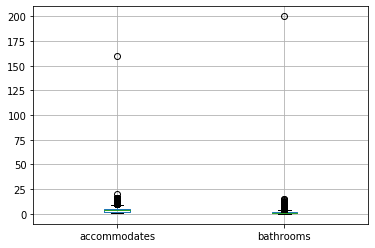

In [39]:
listing1.boxplot(column=['accommodates','bathrooms'])
plt.means=True

Text(0, 0.5, 'Quantidade')

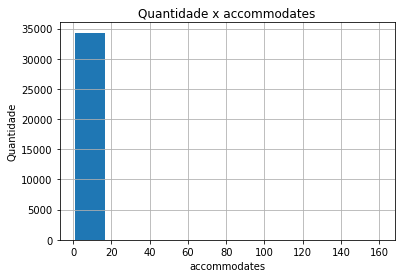

In [40]:
listing1.hist('accommodates')
plt.title('Quantidade x accommodates')
plt.xlabel('accommodates')
plt.ylabel('Quantidade')

Text(0, 0.5, 'Quantidade')

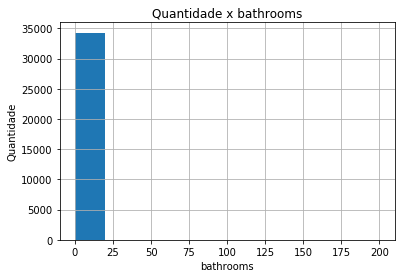

In [41]:
listing1.hist('bathrooms')
plt.title('Quantidade x bathrooms')
plt.xlabel('bathrooms')
plt.ylabel('Quantidade')

##### Para esses 2 casos como é muito discrepante o valor dos outliers, vamos substituir todos os valores maiores que 25 pela média arredondada de cada uma das variáveis: accomodates e bathrooms. Já que as distribuições são assiméetricas mas não possuem a média menor que a mediana

In [42]:
print('Quantidade de outliers para substituir - accomodates: {}'.format(listing1[listing1['accommodates']>20].count()[0]))

Quantidade de outliers para substituir - accomodates: 1


In [43]:
print('Quantidade de outliers para substituir - bathrooms: {}'.format(listing1[listing1['bathrooms']>25].count()[0]))

Quantidade de outliers para substituir - bathrooms: 1


In [44]:
listing_2 = listing1

In [45]:
listing_2['accommodates'].values[listing_2['accommodates'].values >= 25] = 4

In [46]:
listing_2['bathrooms'].values[listing_2['bathrooms'].values >= 25.0] = 2.0

C:\Users\gisel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


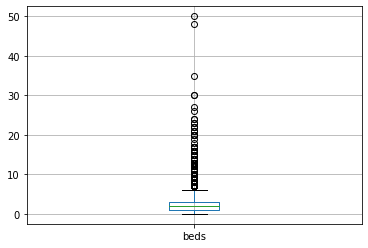

In [47]:
listing_2.boxplot(column=['beds'])
plt.means=True

Text(0, 0.5, 'Quantidade')

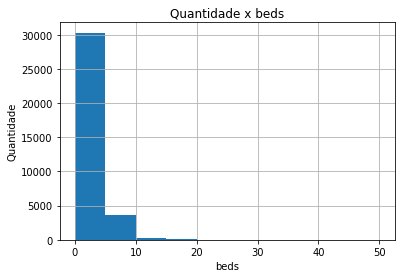

In [48]:
listing_2.hist('beds')
plt.title('Quantidade x beds')
plt.xlabel('beds')
plt.ylabel('Quantidade')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000291C1B38160>,
      dtype=object)

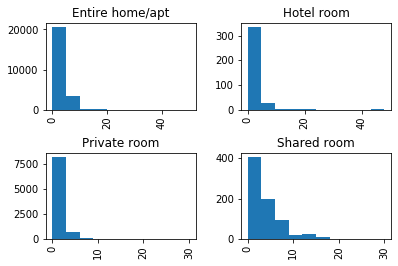

In [49]:
listing_2['beds'].hist(by=listing_2['room_type'])

In [50]:
listing_2.groupby('room_type')['beds'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,24132.0,2.932662,1.949590,0.0,2.0,3.0,4.0,50.0
Hotel room,369.0,2.563686,3.232290,0.0,1.0,2.0,3.0,48.0
Private room,9030.0,1.523477,1.236312,0.0,1.0,1.0,2.0,30.0
Shared room,761.0,3.554534,3.510508,0.0,1.0,2.0,5.0,30.0


In [51]:
# Vamos tro
IQR = listing_2.beds.describe()[6] - listing_2.beds.describe()[4]
quartil_sup_beds = listing_2.beds.quantile(0.75) + IQR * 3
quartil_inf_beds = listing_2.beds.quantile(0.25) - IQR * 3

In [52]:
print('Intervalo de beds com quartil superior: {a} e quartil inferior {b}'.format(a = quartil_sup_beds, b = quartil_inf_beds))

Intervalo de beds com quartil superior: 9.0 e quartil inferior -5.0


In [53]:
print('Quantidade de registros para trocar: {}'.format(listing_2[listing_2['beds']>9.0].count()[0]))

Quantidade de registros para trocar: 365


In [54]:
# Beds média de Shared room sem considerar outlers
listing_2[(listing_2['room_type']=='Shared room') & (listing_2['beds']<9)]['beds'].mean()

2.7457142857142856

In [55]:
listing_2[listing_2['room_type']=='Shared room']['beds'].mean()

3.5545335085413927

In [56]:
print(listing_2.groupby('room_type')['beds'].mean())

room_type
Entire home/apt    2.932662
Hotel room         2.563686
Private room       1.523477
Shared room        3.554534
Name: beds, dtype: float64


In [57]:
# Substituiremos cada um por sua média
def outlier_bed(df):
    df['beds'] = np.where(df['beds']>9, np.random.randint(2, 4,1)[0], df['beds'])
    df['beds'] = np.where(((df['beds']==0) & (df['room_type']=='Entire home/apt')), 3.0, df['beds'])
    df['beds'] = np.where(((df['beds']==0) & (df['room_type']=='Hotel room')), 3.0, df['beds'])
    df['beds'] = np.where(((df['beds']==0) & (df['room_type']=='Private room')), 2.0, df['beds'])
    df['beds'] = np.where(((df['beds']==0) & (df['room_type']=='Shared room')), 4.0, df['beds'])

In [58]:
outlier_bed(listing_2)

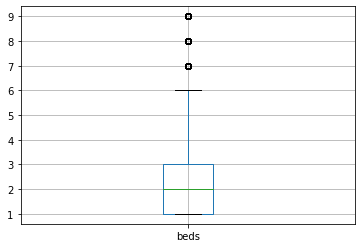

In [59]:
listing_2.boxplot(column=['beds'])
plt.means=True

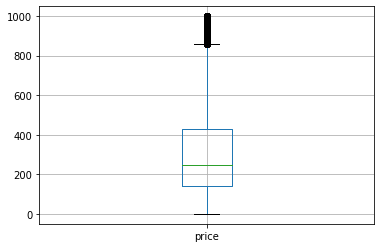

In [60]:
listing_2.boxplot(column=['price'])
plt.means=True

Text(0, 0.5, 'Quantidade')

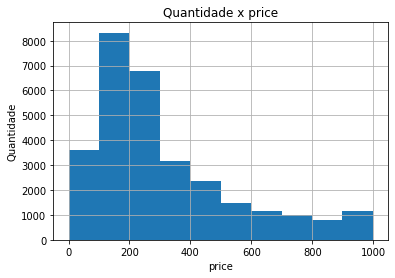

In [61]:
listing_2.hist('price')
plt.title('Quantidade x price')
plt.xlabel('price')
plt.ylabel('Quantidade')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000291C1D5C6A0>,
      dtype=object)

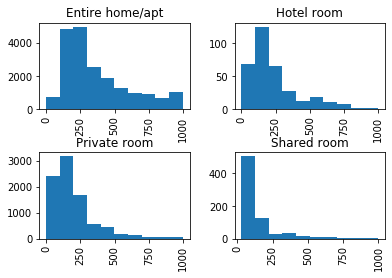

In [62]:
listing_2['price'].hist(by=listing_2['room_type'])

In [63]:
listing_2.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,19874.0,376.638825,249.457980,0.0,183.0,299.0,499.0,999.0
Hotel room,337.0,235.872404,184.303737,0.0,112.0,178.0,299.0,999.0
Private room,8816.0,206.860368,175.160402,0.0,92.0,150.0,250.0,999.0
Shared room,743.0,150.506057,168.992710,29.0,58.0,83.0,158.0,998.0


In [64]:
# Como as distribuições de price são diferentes de acordo com a room_type, vamos substituir os autiliers de cada grupo
IQR = listing_2.price.describe()[6] - listing_2.price.describe()[4]
quartil_sup_price = listing_2.price.quantile(0.75) + IQR * 3
quartil_inf_price = listing_2.price.quantile(0.25) - IQR * 3

In [65]:
print('Intervalo de preço com quartil superior: {a} e quartil inferior {b}'.format(a = quartil_sup_price, b = quartil_inf_price))

Intervalo de preço com quartil superior: 1289.0 e quartil inferior -720.0


In [66]:
print('Quantidade de registros para trocar em price: {}'.format(listing_2[listing_2['price']>11289.0].count()[0]))

Quantidade de registros para trocar em price: 0


##### Assim, não vamos trocar nenhum outlier em price.
* Obs: Não vamos verificar as demais variáveis (outliers) devida falta de tempo

##### Vamos utilizar em nosso modelo apenas as variáveis numéricas, então, tornamos a room_type como numérica, de acordo suas médias de preço: 3 = 'Entire home/apt	', 2 = 'Hotel room', 1 = 'Private room' e 0 = 'Shared room'

In [67]:
def g(x):
    if x['room_type'] == 'Entire home/apt': return 3
    elif x['room_type'] == 'Hotel room': return 2
    elif x['room_type'] == 'Private room': return 1
    else: return 0

listing_2['room_type_2'] = listing_2.apply(g, axis=1)

In [68]:
a = pd.crosstab(index=listing_2['property_type'],
                     columns='%')
a

col_0,%
property_type,
Aparthotel,76
Apartment,26194
Barn,2
Bed and breakfast,166
Boat,25
Boutique hotel,34
Bungalow,13
Cabin,11
Camper/RV,2


In [69]:
# Como a prospery_type não há registros vazios, podemos trasformála em 2 tipos apenas: onde prospery_type='Apartment'=1 e se
# diferente de Apartment = 0
def h(x):
    if x['property_type'] == 'Apartment': return 1
    else: return 0

listing_2['property_type_2'] = listing_2.apply(h, axis=1)

In [70]:
b = pd.crosstab(index=listing_2['property_type_2'],
                     columns='%')
b

col_0,%
property_type_2,
0,8133
1,26194


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000291BE0B7F98>,
      dtype=object)

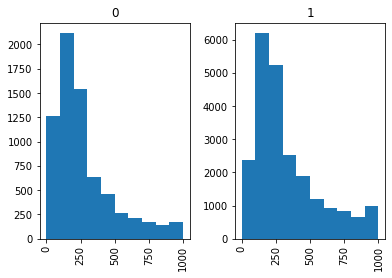

In [71]:
listing_2['price'].hist(by=listing_2['property_type_2'])

In [72]:
listing_2.groupby('property_type_2')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type_2,,,,,,,,
0,6963.0,273.623869,222.154815,0.0,112.0,200.0,349.0,999.0
1,22807.0,333.014995,245.778422,0.0,150.0,250.0,449.0,999.0


In [73]:
# Agora ficamos apenas com as variáveis numéricas
listing_2.dtypes

id                                                int64
host_is_superhost                                object
host_identity_verified                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                         object
beds                                            float64
bed_type                                         object
price                                           float64
guests_included                                   int64
extra_people                                    float64
minimum_nights                                    int64
maximum_nights                                    int64
availability_30                                   int64
availability_60                                   int64
availability_90                                 

In [74]:
numerics = ['int64', 'float64']
numbers = list(listing_2.select_dtypes(include=numerics).columns)
listing_3 = listing_2[numbers]

In [75]:
listing_3.shape

(34327, 20)

In [76]:
listing_3.head()

,id,accommodates,bathrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,room_type_2,property_type_2
0,16374231,3,1.0,1.0,603.0,1,0.0,5,7,30,60,90,365,0,0,2,2,0,3,1
1,16374554,2,1.5,2.0,92.0,1,50.0,7,1125,0,0,0,261,2,1,2,0,2,1,1
2,16376730,5,1.0,5.0,200.0,1,150.0,2,90,20,50,80,340,0,0,1,1,0,3,1
3,16376975,2,1.5,1.0,799.0,1,0.0,2,1125,23,53,83,358,0,0,1,1,0,3,1
4,16377313,2,2.0,1.0,778.0,2,156.0,2,89,7,35,60,335,35,10,45,42,3,3,1


##### Input valores vazios

In [77]:
# Verificamos a quantidade de registros nulos em cada variável para fazermos um imput
listing_3.isnull().sum()

id                                                 0
accommodates                                       0
bathrooms                                         57
beds                                              35
price                                           4557
guests_included                                    0
extra_people                                      82
minimum_nights                                     0
maximum_nights                                     0
availability_30                                    0
availability_60                                    0
availability_90                                    0
availability_365                                   0
number_of_reviews                                  0
number_of_reviews_ltm                              0
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
room_type_2                                   

###### Temos 4 variáveis com valores nulos: bathrooms, beds, price e extra_people.
Para a substituição dos valores nulos, todas as 4 variáveis vamos substituir apenas pela média 

In [78]:
listing_3['bathrooms'].describe()

count    34270.000000
mean         1.682507
std          1.026172
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: bathrooms, dtype: float64

In [79]:
listing_3['bathrooms'].fillna(2, inplace=True)

C:\Users\gisel\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [80]:
listing_3['beds'].describe()

count    34292.000000
mean         2.474163
std          1.570448
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: beds, dtype: float64

In [81]:
listing_3['beds'].fillna(3, inplace=True)

In [82]:
listing_3['price'].describe()

count    29770.000000
mean       319.123816
std        241.768151
min          0.000000
25%        141.000000
50%        245.000000
75%        428.000000
max        999.000000
Name: price, dtype: float64

In [83]:
listing_3['price'].fillna(319, inplace=True)

In [84]:
listing_3['extra_people'].describe()

count    34245.000000
mean        38.044386
std         81.206142
min          0.000000
25%          0.000000
50%          0.000000
75%         50.000000
max        999.000000
Name: extra_people, dtype: float64

In [85]:
listing_3['extra_people'].fillna(38, inplace=True)

In [86]:
listing_3.isnull().sum()

id                                              0
accommodates                                    0
bathrooms                                       0
beds                                            0
price                                           0
guests_included                                 0
extra_people                                    0
minimum_nights                                  0
maximum_nights                                  0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
room_type_2                                     0
property_type_2                                 0


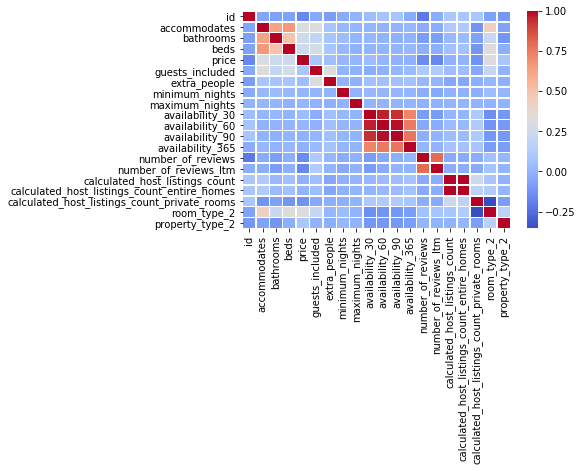

In [87]:
# Verificamos as correlações entre as variáveis que ficamos
sns.heatmap(listing_3.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.5, vmax=1.0, linecolor='white')

###### Algumas variáveis possuem alta correlação então, vamos excluir algumas dela
* Como as variáveis availability_30,  availability_60, availability_90 e availability_365 possuem uma alta correlação, vamos ficar apenas com a  availability_30;
* E as variávies alculated_host_listings_count tambéme tem alta correlação com a calculated_host_listings_count_entire_homes ficaremos apenas com a: alculated_host_listings_count;
* Assim como a number_of_reviews e a number_of_reviews_ltm ficamos com a primeira;

In [88]:
listing_4 = listing_3.drop(columns=['availability_60','availability_90','availability_365', 
                                    'calculated_host_listings_count_entire_homes', 
                                    'number_of_reviews_ltm'])

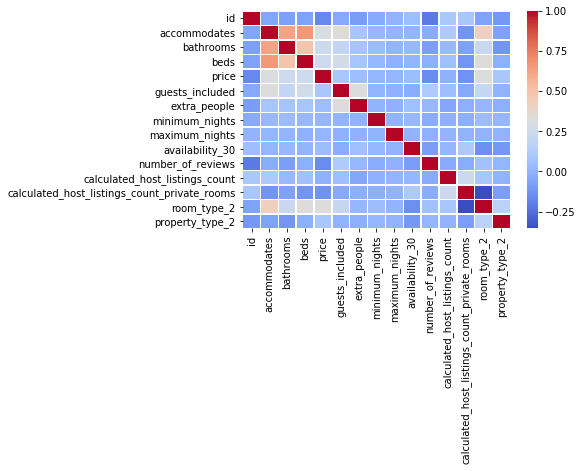

In [89]:
sns.heatmap(listing_4.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.5, vmax=1.0, linecolor='white')

In [90]:
listing_4.shape

(34327, 15)

In [91]:
# Separamos a base de treino e a base de teste
x_train, x_test, y_train, y_test = train_test_split(listing_4.drop(['id','room_type_2'],axis=1),
                                                    listing_4['room_type_2'],
                                                    test_size=0.3,
                                                    random_state=1)

In [92]:
print('Dados para trieno {}'.format(x_train.shape))
print('Dados para teste {}'.format(x_test.shape))

Dados para trieno (24028, 13)
Dados para teste (10299, 13)


In [93]:
# Testando o método KNeighbors com n_neigbors = 2:
knn = KNeighborsClassifier (n_neighbors = 2)

In [94]:
knn.fit (x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [95]:
# Precisão do modelo
knn.score(x_test, y_test)

0.742887658996019

In [96]:
y_pred_2 = knn.predict(x_test)

In [97]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.27      0.43      0.33       228
           1       0.55      0.74      0.63      2756
           2       0.24      0.24      0.24       112
           3       0.90      0.76      0.83      7203

    accuracy                           0.74     10299
   macro avg       0.49      0.54      0.51     10299
weighted avg       0.78      0.74      0.76     10299



In [98]:
# Testando o método KNeighbors com n_neigbors = 3:
knn = KNeighborsClassifier (n_neighbors = 3)

In [99]:
knn.fit (x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [100]:
# Precisão do modelo
knn.score(x_test, y_test)

0.7982328381396252

In [101]:
y_pred_3 = knn.predict(x_test)

In [102]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.33      0.29      0.31       228
           1       0.67      0.62      0.64      2756
           2       0.50      0.14      0.22       112
           3       0.86      0.89      0.87      7203

    accuracy                           0.80     10299
   macro avg       0.59      0.49      0.51     10299
weighted avg       0.79      0.80      0.79     10299



###### Comparando a matriz com n_neigbors =2 e = 3, temos uma melhoria na precisão do modelo em todos os rooms_type, exeto o 3 que é o de maior registros. Entre os dois, ficaríamos com o n_neigbors igual a 3, melhorando a precisão do modelo, mesmo que piore um pouco um dos tipos.

In [103]:
# Modelo: GradientBoostingClassifier - árvore de decisão
from sklearn.ensemble import GradientBoostingClassifier

In [104]:
clf = GradientBoostingClassifier(random_state = 0)
clf.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [105]:
# Precisão do modelo:
clf.score(x_test, y_test)

0.959704825711234

In [106]:
y_pred_gradient = clf.predict(x_test)

In [107]:
print(classification_report(y_test, y_pred_gradient))

              precision    recall  f1-score   support

           0       0.73      0.45      0.56       228
           1       0.95      0.97      0.96      2756
           2       0.77      0.37      0.50       112
           3       0.97      0.98      0.98      7203

    accuracy                           0.96     10299
   macro avg       0.86      0.69      0.75     10299
weighted avg       0.96      0.96      0.96     10299



##### Aquí, com o modelo Gradient Boosting, além da precisão do modelo ser maior de uma manera geral, olhando por property_type também é, assim, ficaríamos com o modelo de árvore de decisão.

#### Avaliação de Conhecimento de SQL
* Exercício 1

In [108]:
# Primeiro vamoms importa as outras 2 tabelas que vamos utilizar, já temos a listings
reviews = pd.read_sql_query('''SELECT * FROM reviews;''', cnx)

In [109]:
calendar = pd.read_sql_query('''SELECT * FROM calendar;''', cnx)

In [110]:
# Verificamos o que há ns 3:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,16374231,https://www.airbnb.com/rooms/16374231,20190923212307,2019-09-24,Conjugado Catete,"Apartamento conjugado, ambiente agradável, pró...",None,"Apartamento conjugado, ambiente agradável, pró...",none,None,None,None,None,None,- Respeitar os horários e regras do codomínio,None,None,https://a0.muscache.com/im/pictures/88f5b2f4-9...,None,51007197,https://www.airbnb.com/users/show/51007197,Paulo,2015-12-10,BR,None,N/A,N/A,N/A,f,https://a0.muscache.com/im/pictures/064cd049-8...,https://a0.muscache.com/im/pictures/064cd049-8...,Flamengo,2,2,"['email', 'phone']",t,f,"Rio de Janeiro, Rio de Janeiro, Brazil",Glória,Catete,None,Rio de Janeiro,Rio de Janeiro,22220-000,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.92383,-43.17709,t,Apartment,Entire home/apt,3,1.0,1,1,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,""...",None,$603.00,None,None,None,None,1,$0.00,5,7,5,5,7,7,5.0,7.0,32 months ago,t,30,60,90,365,2019-09-24,0,0,None,None,None,None,None,None,None,None,None,f,None,None,t,f,flexible,f,f,2,2,0,0,None
1,16374554,https://www.airbnb.com/rooms/16374554,20190923212307,2019-09-24,Best point in Copacabana,"Bedroom with 14 mts2, wifi, single bed, wardro...","The best part of Copacabana, very easy transpo...","Bedroom with 14 mts2, wifi, single bed, wardro...",none,None,None,None,"24 hours doormen, big bathroom, fast kitchen a...",None,None,None,None,https://a0.muscache.com/im/pictures/5c128a1a-a...,None,77507320,https://www.airbnb.com/users/show/77507320,Judith,2016-06-13,Brazil,"Sou judy, recebo estudantes de intercâmbio há ...",within a day,60%,N/A,f,https://a0.muscache.com/im/pictures/7460e850-4...,https://a0.muscache.com/im/pictures/7460e850-4...,Copacabana,2,2,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,None,Rio de Janeiro,Rio de Janeiro,22020-020,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.96427,-43.1772,t,Apartment,Private room,2,1.5,1,2,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",None,$92.00,None,None,$0.00,$0.00,1,$50.00,7,1125,7,7,1125,1125,7.0,1125.0,yesterday,t,0,0,0,261,2019-09-24,2,1,2018-01-02,2019-03-07,100,10,10,10,10,10,10,f,None,None,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.10
2,16376730

In [111]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,536931,133275410,2017-02-21,24439166,Thaís Kellen,Excelente apartamento. Atendimento excelente n...
1,536931,135574792,2017-03-05,82534892,Diego Fernando,"Todo muy bien, el único tema es el aire acondi..."
2,536931,141226421,2017-04-02,110989891,Juan Martín,Es un apartamento ideal para pasar unas excele...
3,536931,147941805,2017-04-29,30796353,Lu,"Hermoso departamento. Muy bien ubicado, cerca ..."
4,536931,148877060,2017-05-01,43348634,Mona,Charle's place is beautiful! Excellent locatio...


In [112]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,10923045,2020-07-12,f,$500.00,$500.00,5,30
1,10923045,2020-07-13,f,$500.00,$500.00,5,30
2,10923045,2020-07-14,f,$500.00,$500.00,5,30
3,10923045,2020-07-15,f,$500.00,$500.00,5,30
4,10923045,2020-07-16,f,$500.00,$500.00,5,30


In [113]:
calendar.dtypes

listing_id        object
date              object
available         object
price             object
adjusted_price    object
minimum_nights    object
maximum_nights    object
dtype: object

In [114]:
# ajustando o tipo da variável date para datetime
columns_to_numeric(calendar,['listing_id','minimum_nights','maximum_nights'])

In [115]:
calendar[['date']] = calendar[['date']].apply(pd.to_datetime)

In [116]:
calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                     object
adjusted_price            object
minimum_nights           float64
maximum_nights           float64
dtype: object

In [117]:
# Ficando apenas com as acomodações disponíveis: available = 't'
calendar2 = calendar[calendar['available'] == 't']

In [118]:
# Ficando apenas com o perído que vamos utilizar - outubro de 2019
calendar2 = calendar2[calendar2['date'] <= '2019-10-31']

In [119]:
calendar2 = calendar2[calendar2['date'] >= '2019-10-01']

In [120]:
calendar2.shape

(565466, 7)

In [121]:
calendar2 = pd.DataFrame(calendar2).reset_index().rename(columns = {'listing_id': 'id'})

In [122]:
calendar2.head()

,index,id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,397,10923411,2019-10-01,t,$150.00,$150.00,2.0,240.0
1,398,10923411,2019-10-02,t,$150.00,$150.00,2.0,240.0
2,399,10923411,2019-10-03,t,$150.00,$150.00,2.0,240.0
3,400,10923411,2019-10-04,t,$150.00,$150.00,2.0,240.0
4,401,10923411,2019-10-05,t,$150.00,$150.00,2.0,240.0


In [123]:
# ficamos com as variáveisl da tabela listing que vamos utilizar:
listing_sql = listing[['id', 'property_type']]

In [124]:
listing_sql[['id']] = listing_sql[['id']].apply(pd.to_numeric)

C:\Users\gisel\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [125]:
listing_sql.dtypes

id                int64
property_type    object
dtype: object

In [126]:
listing_sql.shape

(34327, 2)

In [127]:
# Cruando a tabela calendar2 com a listing_sql pelo id
anuncios = calendar2.merge(listing_sql, on = ['id'], how = 'left')
anuncios.head()

,index,id,date,available,price,adjusted_price,minimum_nights,maximum_nights,property_type
0,397,10923411,2019-10-01,t,$150.00,$150.00,2.0,240.0,Apartment
1,398,10923411,2019-10-02,t,$150.00,$150.00,2.0,240.0,Apartment
2,399,10923411,2019-10-03,t,$150.00,$150.00,2.0,240.0,Apartment
3,400,10923411,2019-10-04,t,$150.00,$150.00,2.0,240.0,Apartment
4,401,10923411,2019-10-05,t,$150.00,$150.00,2.0,240.0,Apartment


In [128]:
# Ficamos apenas com os property_type = 'Apartment'
anuncios2 = anuncios[anuncios['property_type'] == 'Apartment']

In [129]:
# Fazendo uma variável de semana
anuncios2['Semana'] = anuncios2['date'].dt.to_period('W-THU')

C:\Users\gisel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
# Ficando apenas com as variáveis que iremos fazer as contas:
anuncios3 = anuncios2[['id', 'Semana']]

##### Aqui teremos o total de anúnicos únicos por semana das acomodações do tipo Apartamento disponíveisl

In [131]:
anuncios3.groupby('Semana')['id'].nunique()

Semana
2019-09-27/2019-10-03    12060
2019-10-04/2019-10-10    15203
2019-10-11/2019-10-17    15647
2019-10-18/2019-10-24    15665
2019-10-25/2019-10-31    15825
Freq: W-THU, Name: id, dtype: int64

#### Avaliação de Conhecimento de SQL
* Exercício 2

In [132]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,536931,133275410,2017-02-21,24439166,Thaís Kellen,Excelente apartamento. Atendimento excelente n...
1,536931,135574792,2017-03-05,82534892,Diego Fernando,"Todo muy bien, el único tema es el aire acondi..."
2,536931,141226421,2017-04-02,110989891,Juan Martín,Es un apartamento ideal para pasar unas excele...
3,536931,147941805,2017-04-29,30796353,Lu,"Hermoso departamento. Muy bien ubicado, cerca ..."
4,536931,148877060,2017-05-01,43348634,Mona,Charle's place is beautiful! Excellent locatio...


In [133]:
# Transformando as variáveis que vamos utilizar
columns_to_numeric(reviews,['listing_id','id','reviewer_id'])

In [134]:
reviews[['date']] = reviews[['date']].apply(pd.to_datetime)

In [135]:
# Filtranso a data dos reviews até 01 de outubro de 2019
reviews2 = reviews[reviews['date'] <= '2019-10-01']

In [136]:
# Fazendo uma variável de semana
reviews2['Semana'] = reviews2['date'].dt.to_period('W-THU')

In [137]:
reviews2.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Semana
0,536931,133275410,2017-02-21,24439166,Thaís Kellen,Excelente apartamento. Atendimento excelente n...,2017-02-17/2017-02-23
1,536931,135574792,2017-03-05,82534892,Diego Fernando,"Todo muy bien, el único tema es el aire acondi...",2017-03-03/2017-03-09
2,536931,141226421,2017-04-02,110989891,Juan Martín,Es un apartamento ideal para pasar unas excele...,2017-03-31/2017-04-06
3,536931,147941805,2017-04-29,30796353,Lu,"Hermoso departamento. Muy bien ubicado, cerca ...",2017-04-28/2017-05-04
4,536931,148877060,2017-05-01,43348634,Mona,Charle's place is beautiful! Excellent locatio...,2017-04-28/2017-05-04


In [138]:
df = reviews2.groupby(['reviewer_id','Semana'])['listing_id'].count()

In [139]:
df.head()

reviewer_id  Semana               
5            2015-08-21/2015-08-27    1
283          2018-12-28/2019-01-03    1
420          2017-12-08/2017-12-14    1
1060         2013-09-13/2013-09-19    1
1065         2015-03-06/2015-03-12    1
Name: listing_id, dtype: int64